In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw, SpectralModel
from gammapy.utils.modeling import Parameter, ParameterList
from scipy.stats import norm

## simulate a powerlaw observation

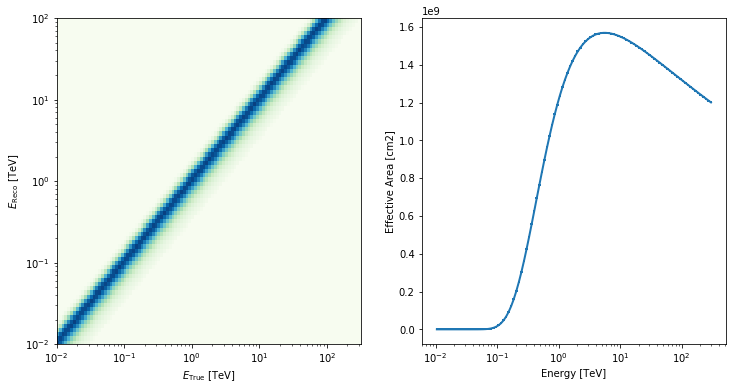

In [2]:
# define the IRFs
e_true = np.logspace(-2, 2.5, 109) * u.TeV
e_reco = np.logspace(-2,2, 79) * u.TeV

edisp = EnergyDispersion.from_gauss(e_true=e_true, e_reco=e_reco, sigma=0.2, bias=0)
aeff = EffectiveAreaTable.from_parametrization(energy=e_true)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
edisp.plot_matrix(ax=axes[0])
aeff.plot(ax=axes[1])

In [3]:
# define the model
index = 2.5 * u.Unit('')
amplitude = 2e-11 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

# define the background model
bkg_index = 3 * u.Unit('')
bkg_amplitude = 3e-12 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

pwl = PowerLaw(index=index, amplitude=amplitude, reference=reference)
bkg_model = PowerLaw(index=bkg_index, amplitude=bkg_amplitude, reference=reference)
alpha = 0.3

livetime = 10 * u.min

In [4]:
n_obs = 1
seeds = np.arange(n_obs)

sim = SpectrumSimulation(aeff=aeff,
                         edisp=edisp,
                         source_model=pwl,
                         livetime=livetime,
                         background_model=bkg_model,
                         alpha=alpha)

sim.run(seeds)
print(sim.result)
print(sim.result[0])

SpectrumObservationList
Number of observations: 1
*** Observation summary report ***
Observation Id: 0
Livetime: 0.167 h
On events: 75
Off events: 50
Alpha: 0.300
Bkg events in On region: 15.00
Excess: 60.00
Excess / Background: 4.00
Gamma rate: 6.00 1 / min
Bkg rate: 0.02 1 / min
Sigma: 8.83
energy range: 0.01 TeV - 100.00 TeV


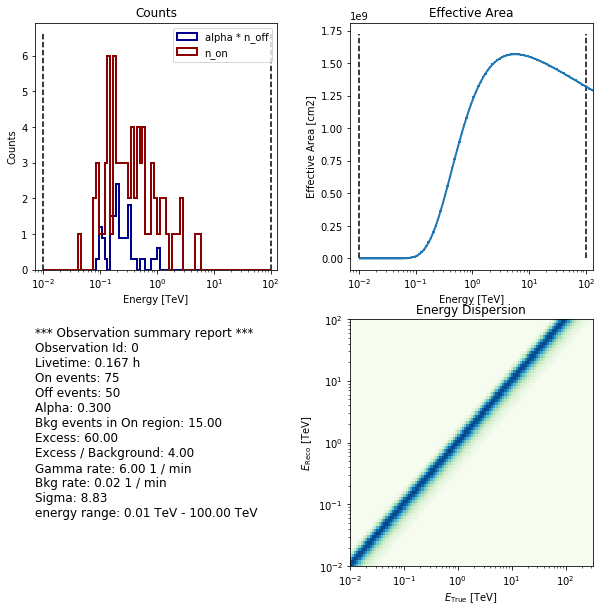

In [5]:
sim.obs.peek()

In [6]:
fit = SpectrumFit(obs_list=sim.obs, model=pwl.copy(), stat='wstat', method='iminuit', err_method='iminuit')
fit.fit_range = [1e-2, 1e2] * u.TeV
fit.fit()
fit.est_errors()
print(fit.result[0])

/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/utils/fitting/iminuit.py:44: InitialParamWarning: errordef is not given. Default to 1.
  **minuit_kwargs)
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/utils/fitting/iminuit.py:44: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.
  **minuit_kwargs)
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/utils/fitting/iminuit.py:44: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
  **minuit_kwargs)
/afs/ifh.de/group/amanda/scratch/cosimo/software/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


FCN = 42.418162195936276 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 2.3164871529005241e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,index,2.5852,0.210026,0,0,,,
2,amplitude,1.78203e-11,4.12088e-12,0,0,,,
3,reference,1,1,0,0,,,FIXED



Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	    index 2.586e+00 2.100e-01                 nan nan  False
	amplitude 1.785e-11 4.121e-12 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00             TeV nan nan   True

Covariance: 

	name/name   index   amplitude
	--------- --------- ---------
	    index    0.0441 -6.72e-13
	amplitude -6.72e-13   1.7e-23 

Statistic: 42.418 (wstat)
Fit Range: [1.e-02 1.e+02] TeV



## estimate the error
### sample the 1D contour

In [7]:
# what is the covariance
fit.covariance

array([[ 4.41108251e-02, -6.71806456e-13],
       [-6.71806456e-13,  1.69816246e-23]])

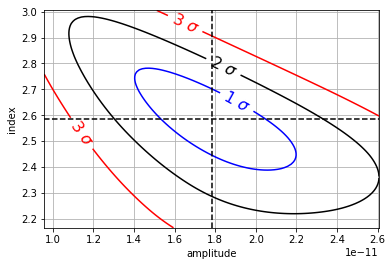

In [8]:
D = fit._iminuit_fit.draw_contour('amplitude', 'index', bins=100, show_sigma=True)
None

In [9]:
fit._iminuit_fit.draw_contour

<function Minuit.draw_contour>

In [10]:
X, Y, V = D

In [11]:
V = np.array(V)
epsilon = 0.2
mask = np.where((-epsilon/2 < (V - 1)) & ((V - 1) < epsilon/2), 1, 0).astype(np.bool)

Text(0.5,0,'index [TeV-1 cm-2 s-1]')

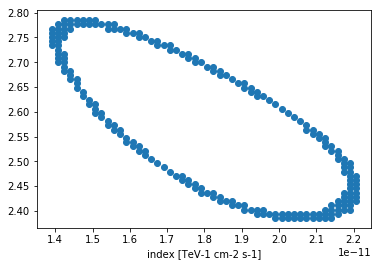

In [12]:
mask.shape
XS, YS = np.meshgrid(X, Y)
XS[mask], YS[mask]
plt.plot(XS[mask], YS[mask], marker='o', ls='')
plt.xlabel('ampltiude [TeV-1 cm-2 s-1]')
plt.xlabel('index [TeV-1 cm-2 s-1]')

### multivariate sampling

In [13]:
amplitude = fit.result[0].model.parameters['amplitude'].value
index = fit.result[0].model.parameters['index'].value
reference = fit.result[0].model.parameters['reference'].value

covariance = fit.result[0].covariance

pars = np.asarray([index, amplitude])
dim_sample = 200

sampled_index, sampled_amplitude = np.random.multivariate_normal(
    pars, 
    covariance, 
    dim_sample
).T

In [14]:
# plot the sampled values
energies = np.logspace(-2,2,100) * u.TeV
sigma = 1

flux_min = []
flux_max= []

for ene in energies:
    # loop through the sampled values and estimate flux at this energies
    _flux = []
    for amp, ind in zip(sampled_amplitude, sampled_index):
        # give them the units of the sampled quantities
        amp *= u.Unit('TeV-1 cm-2 s-1')
        ind *= u.Unit('')
        _flux.append(
            PowerLaw.evaluate(
            energy=ene, 
            index=ind,
            amplitude=amp,
            reference=reference).value
        )
    # now to define the minimum and maximum flux let's take the n-sigma containment
    low_quantile = norm.cdf(-sigma)
    high_quantile = norm.cdf(sigma)
    _flux_min = np.percentile(np.asarray(_flux), 100 * low_quantile)
    _flux_max = np.percentile(np.asarray(_flux), 100 * high_quantile)

    flux_min.append(_flux_min)
    flux_max.append(_flux_max)


# which flux unit? evaluate the model with the final parameters (from which we have sampled)
# to obtain the proper units
flux_min = np.asarray(flux_min) * u.Unit('TeV-1 cm-2 s-1')
flux_max = np.asarray(flux_max) * u.Unit('TeV-1 cm-2 s-1')

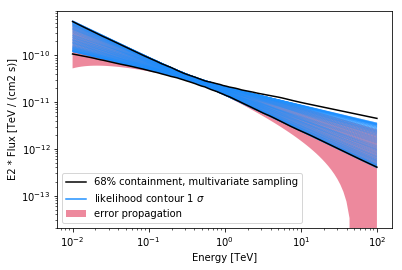

In [15]:
for amp, index in zip(XS[mask], YS[mask]):
    PowerLaw(
        index=index, 
        amplitude=amp * u.Unit('TeV-1 cm-2 s-1')
            ).plot(energy_range=fit.fit_range, energy_power=2, color='dodgerblue', lw=0.2)
    
    
#fit.result[0].model.plot(fit.fit_range, energy_power=2)
fit.result[0].model.plot_error(fit.fit_range, energy_power=2, color='crimson', alpha=0.5, label='error propagation')
plt.plot(energies, energies**2 * flux_min, color='k', label='68% containment, multivariate sampling')
plt.plot(energies, energies**2 * flux_max, color='k')
plt.plot(0,0,label='likelihood contour 1 $\sigma$', color='dodgerblue')
plt.legend()